In [1]:
import xarray as xr
import climtas.io
import dask
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Matplotlib is building the font cache; this may take a moment.


In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37791,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.143:43959,Total threads: 1
Dashboard: http://10.0.128.143:33931/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:40691,


In [3]:
anom = xr.open_dataarray('/g/data/w40/rl5183/progress_files/anom.nc', chunks={'member':1}).sel(time=slice('1901-9', '2015-12')) # take time slice a few months larger on either side for smoothing

In [4]:
anom

,Array,Chunk
Bytes,52.33 GiB,678.30 MiB
Shape,"(79, 1372, 180, 360)","(1, 1372, 180, 360)"
Count,159 Tasks,79 Chunks
Type,float64,numpy.ndarray


In [5]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [6]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [7]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1901-11', '2015-10'))/sst_std

In [8]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [9]:
def ensemble_correlation(data, nino):
    
    anom = data
    
    # Smooth with 3-month running mean
    anom_rolling = anom.rolling(time=3).mean().sel(time=slice('1901-11', '2015-10'))
    
    # Take mean over every quarter 
    quarterly_anom = anom_rolling.resample(time='QS-NOV').mean('time')

    # Calculate instantaneous correlation 
    quarterly_correlation = func.correlate_nino_by_month(quarterly_anom, nino)
    
    return quarterly_correlation 

In [10]:
%%time 
correlation_list = []
for m in anom.member:
    correlation_list.append(ensemble_correlation(anom.sel(member=m), nino_ndj))

CPU times: user 3h 12min 41s, sys: 25min 1s, total: 3h 37min 43s
Wall time: 4h 38min 18s


In [11]:
correlations = xr.concat(correlation_list, dim='member')

In [12]:
correlations

<xarray.DataArray (member: 79, month: 4, latitude: 180, longitude: 360)>
array([[[[-9.77157345e-02, -9.71660629e-02, -9.66474671e-02, ...,
          -9.86970155e-02, -9.83674497e-02, -9.80108516e-02],
         [-1.14206050e-01, -1.13335104e-01, -1.12640812e-01, ...,
          -1.15940187e-01, -1.15363898e-01, -1.14812712e-01],
         [-1.21875517e-01, -1.21110687e-01, -1.20562034e-01, ...,
          -1.24458663e-01, -1.23546523e-01, -1.22532921e-01],
         ...,
         [-5.07071586e-02, -4.92651774e-02, -4.79199611e-02, ...,
          -5.35816005e-02, -5.26981230e-02, -5.18140301e-02],
         [-8.57030375e-02, -8.46505321e-02, -8.38417366e-02, ...,
          -8.79216486e-02, -8.72724463e-02, -8.64637769e-02],
         [-1.16916113e-01, -1.16417034e-01, -1.15904750e-01, ...,
          -1.18030601e-01, -1.17727352e-01, -1.17361222e-01]],

        [[ 7.75204872e-03,  8.06542012e-03,  8.34312999e-03, ...,
           8.59728204e-03,  8.21132959e-03,  7.84847831e-03],
         [-2.68286962e-02, -2.62618723e-02, -2.58321608e-02, ...,
          -2.70274225e-02, -2.69983285e-02, -2.70844514e-02],
         [-4.10294763e-02, -4.06878270e-02, -4.02830959e-02, ...,
          -4.27154790e-02, -4.21590981e-02, -4.15763753e-02],
...
         [-4.43893269e-02, -4.65485396e-02, -4.84840340e-02, ...,
          -3.88197586e-02, -4.06247552e-02, -4.25404958e-02],
         [-5.75493356e-02, -5.90979136e-02, -6.04392253e-02, ...,
          -5.33364585e-02, -5.47824814e-02, -5.62537473e-02],
         [-7.49479282e-02, -7.56144717e-02, -7.60795018e-02, ...,
          -7.32347198e-02, -7.38587929e-02, -7.44747892e-02]],

        [[-6.37052296e-02, -6.33361596e-02, -6.29770676e-02, ...,
          -6.41188220e-02, -6.40535846e-02, -6.39336579e-02],
         [-8.38188428e-02, -8.31876895e-02, -8.27294935e-02, ...,
          -8.44802250e-02, -8.42381481e-02, -8.40542199e-02],
         [-9.76290773e-02, -9.73001497e-02, -9.70302976e-02, ...,
          -9.84443566e-02, -9.81845927e-02, -9.78817002e-02],
         ...,
         [-1.68597554e-02, -1.56946720e-02, -1.47473646e-02, ...,
          -1.84241524e-02, -1.79963552e-02, -1.74689951e-02],
         [-6.09283450e-03, -5.67493141e-03, -5.25104435e-03, ...,
          -6.71500694e-03, -6.57727093e-03, -6.33055802e-03],
         [-3.92099412e-04, -9.21133161e-05,  2.01559723e-04, ...,
          -1.14945513e-03, -9.53751339e-04, -6.37276822e-04]]]])
Coordinates:
  * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 72 73 74 75 76 77 78 79 80
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * month      (month) int64 2 5 8 11

In [13]:
# Save as netcdf
correlations.to_netcdf('/g/data/w40/rl5183/20CR/temp/monthly_temp_correlations_all_members.nc')

In [3]:
correlations = xr.open_dataarray('/g/data/w40/rl5183/20CR/temp/monthly_temp_correlations_all_members.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/local/eg3/rl5183/tmp/ipykernel_2444504/176745941.py:21: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('ensemble_mean_corr_tmp.jpg', bbox_inches='tight', dpi=300, quali

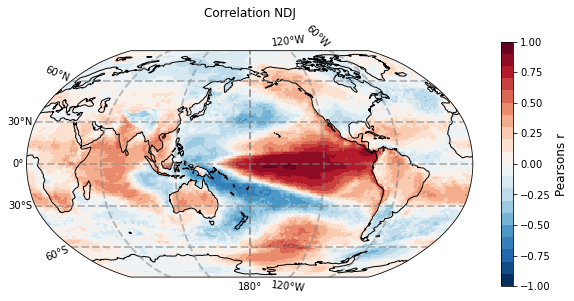

In [4]:
# Plot first member to check 
fig = plt.figure(figsize=(10,5))

vmin=-1
vmax=1

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = correlations.sel(month=11).sel(member=1).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Correlation NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Pearsons r', fontsize=12)

# plt.savefig('ensemble_mean_corr_tmp.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [16]:
# Calculate standrd deviation between ensemble members
ensemble_std = np.apply_along_axis(np.std, 0, correlations)

In [17]:
# Covert to xarray
ensemble_std = xr.DataArray(ensemble_std, coords=correlations.mean(dim='member').coords)
# Save as netcdf 
ensemble_std.to_netcdf('/g/data/w40/rl5183/20CR/temp/tmp_ensemble_std_corr_1901_2015.nc')